In [24]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

rng = np.random.default_rng()

# Question 1

In [25]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(pretrained=True)
model.eval()

# For Preprocessing the input images


preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

/home/ayush/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ayush/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# # my changes
# images = []
# labels = []
# for i in range(1,6):
#     img = Image.open(f"i{i}.jpg").convert('RGB')
#     # print(img.shape)
#     img = preprocess(img)
#     img.requires_grad = True
#     # images.append(img)
#     img = img*2 - 1
#     img = torch.nn.functional.relu(img)
#     print(img.shape)

#     batch= torch.unsqueeze(img, 0)
#     prediction = model(batch).squeeze(0).softmax(0)

#     class_id = prediction.argmax().item()
#     score = prediction[class_id].item()
#     category_name = weights.meta["categories"][class_id]
#     labels.append(f"{category_name}: {100 * score:.1f}%")

# f, axarr = plt.subplots(1, 5)
# f.dpi = 225
# for i in range(5):
#     axarr[i].set_title(labels[i], fontsize = 6)
#     axarr[i].axis("off")
#     axarr[i].imshow(images[i].detach().permute(1, 2, 0))

# plt.show()

Prprocessing the input images for resnet-50

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


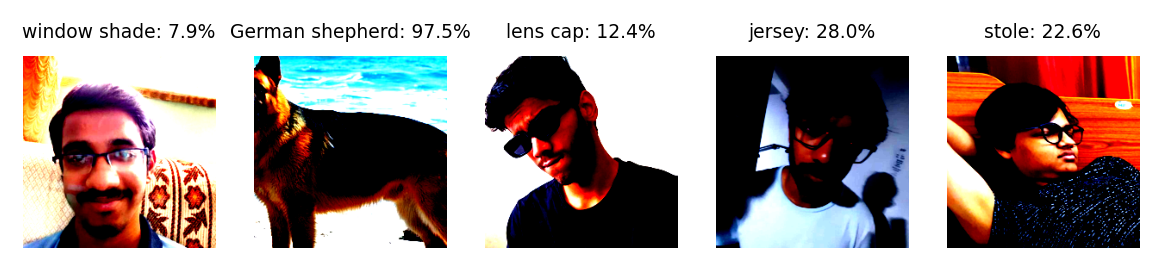

In [27]:
images = []
labels = []
for i in range(1,6):
    img = Image.open(f"i{i}.jpg").convert('RGB')
    img = preprocess(img)
    img.requires_grad = True
    images.append(img)

    batch= torch.unsqueeze(img, 0)
    print(batch.shape)
    prediction = model(batch).squeeze(0).softmax(0)

    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    labels.append(f"{category_name}: {100 * score:.1f}%")

f, axarr = plt.subplots(1, 5)
f.dpi = 225
for i in range(5):
    axarr[i].set_title(labels[i], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(images[i].detach().permute(1, 2, 0))

plt.show()


## a) Vanilla Backpropagation visualization

KeyboardInterrupt: 

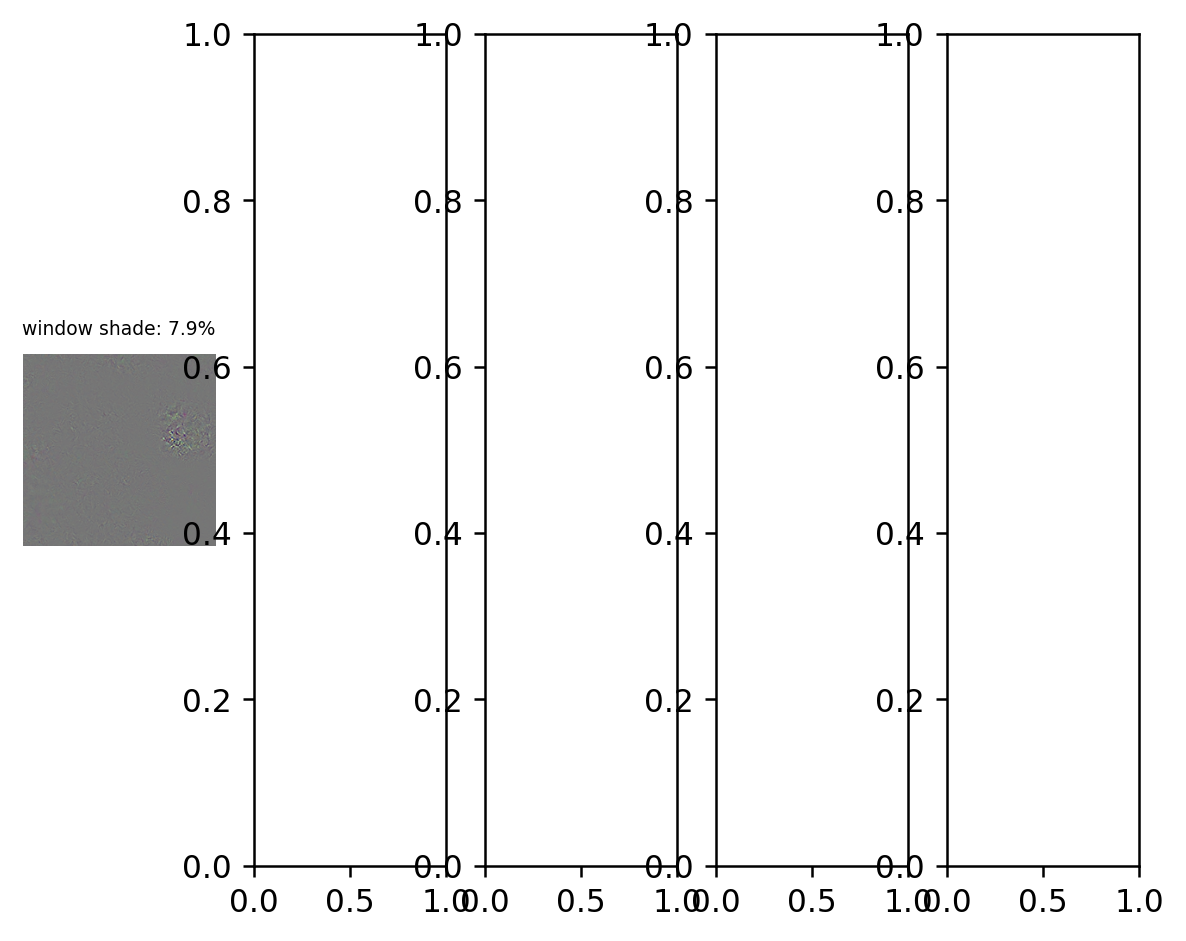

In [28]:
def vanilla_backprop(input_image):

    model = resnet50(pretrained= True)
    model.eval()
    prediction = model(torch.unsqueeze(input_image, 0)).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()

    scores = torch.zeros((1000))
    scores[class_id] = 100
    model.zero_grad()
    prediction.backward(scores)

    return input_image.grad

# for (name, module) in model.named_modules():
#     print("name = ", name)
#     print("module = ", module)

f, axarr = plt.subplots(1, 5)
f.dpi = 225

for i in range(5):
    # print(images[i].grad)
    grads = vanilla_backprop(images[i])

    grads = grads - torch.min(grads)
    grads = grads / torch.max(grads)
    grads = grads * 255

    axarr[i].set_title(labels[i], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(grads.permute(1, 2, 0).detach().numpy().astype(np.uint8))


## b) Guided Backpropagation Visualization

In [ ]:
def guided_backprop_hook(module, grad_in, grad_out):
    modified_output = torch.nn.functional.relu(grad_in[0])

    return (modified_output,)
    

/home/ayush/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


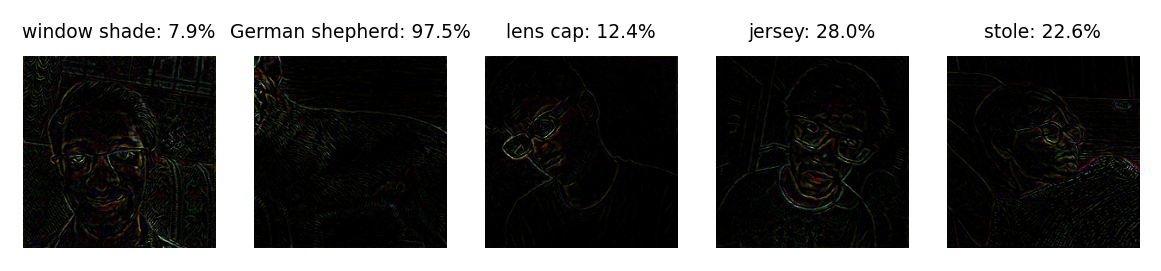

In [ ]:
def guided_backprop(input_image):

    model = resnet50(pretrained= True)
    for (name, module) in model.named_modules():
        if(isinstance(module, torch.nn.ReLU)):
            module.register_backward_hook(guided_backprop_hook)

    model.eval()
    prediction = model(torch.unsqueeze(input_image, 0)).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()

    scores = torch.zeros((1000))
    # for clear visualization
    scores[class_id] = 1000
    model.zero_grad()
    prediction.backward(scores)

    return input_image.grad


f, axarr = plt.subplots(1, 5)
f.dpi = 225

for i in range(5):
    # print(images[i].grad)
    grads = guided_backprop(images[i])
    grads= torch.nn.functional.relu(grads)
    grads= grads** 0.75

    grads = grads - torch.min(grads)
    grads = grads / torch.max(grads)
    grads = grads * 255

    axarr[i].set_title(labels[i], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(grads.permute(1, 2, 0).detach().numpy().astype(np.uint8))


## c) CAM Visualziation

In [ ]:
model = resnet50(pretrained= True)

# Extracting weights for CAM
def extract_weights(model):
    for name, param in model.named_parameters():
        if name =="fc.weight":
            return param

weights = extract_weights(model)  

In [ ]:
act_maps = torch.zeros(0)
def forward_hook(model, input, output):
        global act_maps
        act_maps = input[0]

In [ ]:
def RELU(x):
  return np.maximum(x, 0)

In [ ]:
def get_CAM(input_image, weights):

    global act_maps
    model = resnet50(pretrained= True)
    for name, module in model.named_modules():
        print(f"name = {name}, module = {module}")
        if name == "avgpool":
            module.register_forward_hook(forward_hook)

    model.eval()
    prediction = model(torch.unsqueeze(input_image, 0)).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()

    size_upsample = (224, 224)
    bs, c, h, w = act_maps.shape

    output = np.zeros((7,7))
    act_maps = act_maps[0]
    for i in range(c):
        map =  torch.reshape(act_maps[i], (h,w))
        heatmap = weights[class_id][i].item() * map
        heatmap = torch.reshape(heatmap, (h, w)).detach().numpy()


        output += heatmap
    
    output = output - np.min(output)
    heatmap_img = output / np.max(output)
    heatmap_img = np.uint8(255 * heatmap_img)
    output_cam = (cv2.resize(heatmap_img, size_upsample))

    # output_cam = RELU(output_cam)
    return output_cam



In [ ]:
def show_cam(CAM, width, height, orig_image, index):
        heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.5 + orig_image * 0.5
        cv2.waitKey(0)
        cv2.imwrite(f"CAM_{index}.jpg", result)

name = , module = ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(

TypeError: 'AxesSubplot' object is not subscriptable

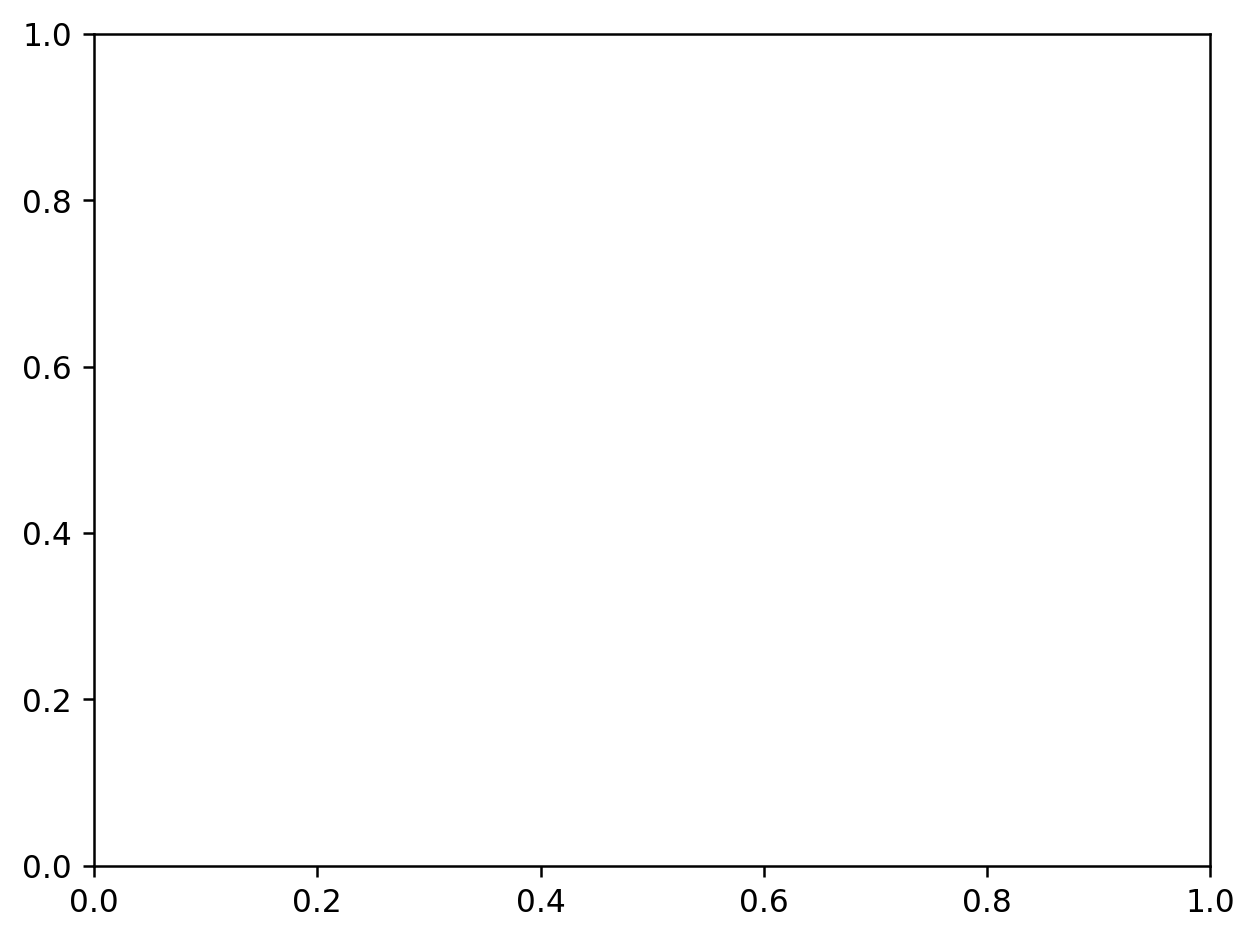

In [ ]:
f, axarr = plt.subplots(1, 1)
f.dpi = 225

for i in range(1):
    # print(images[i].grad)
    image = cv2.imread(f"i{i+1}.jpg")
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    CAM = get_CAM(images[i], weights)
    show_cam(CAM, width ,height, orig_image, i+1)

    img = plt.imread(f"CAM_{i+1}.jpg")
    axarr[i].set_title(labels[i], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(img)

## d) Guided Grad-CAM

name = , module = ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(

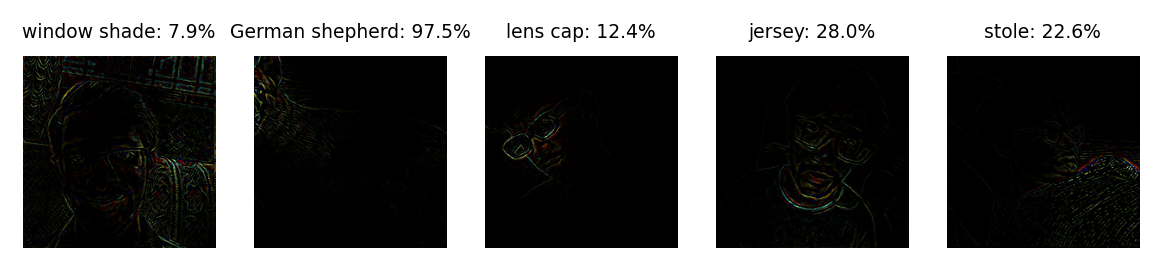

In [ ]:
def guided_grad_CAM(input_image, weights):
    
    cam_op = get_CAM(input_image, weights)
    grad_cam_op = RELU(cam_op)
    guided_backprop_op = guided_backprop(input_image)

    grads = guided_backprop_op
    grads= torch.nn.functional.relu(grads)
    grads= grads** 0.75
    grads = grads - torch.min(grads)
    grads = grads / torch.max(grads)
    grads = grads * 255

    grads = grads.permute(1, 2, 0).detach().numpy().astype(np.uint8)
    grads_op = np.zeros((224, 224, 3))


    grads_op[:, :, 0]  = grad_cam_op
    grads_op[:, :, 1] = grad_cam_op
    grads_op[:, :, 2] = grad_cam_op

    output = np.multiply(grads_op, grads)

    return output

f, axarr = plt.subplots(1, 5)
f.dpi = 225

for i in range(5):
    # print(images[i].grad)
    grads = guided_grad_CAM(images[i], weights)

    grads = grads - np.min(grads)
    grads = grads / np.max(grads)
    grads = grads * 255

    axarr[i].set_title(labels[i], fontsize = 6)
    axarr[i].axis("off")
    axarr[i].imshow(grads.astype(np.uint8))
    


# Question 2

In [ ]:
def grad_x(x):
    return 20*x

def grad_y(y):
    return 2*y

In [ ]:
# Random Intialization of points
i = rng.integers(low=15, high=20, size=2)
x = i[0]
y = i[1]

In [ ]:
def SGD(x, y, num_iters= 50, alpha= 0.06):

    arr_x = np.zeros((51,))
    arr_y = np.zeros((51,))

    for i in range(num_iters):
        arr_x[i] = x
        arr_y[i] = y

        dx = grad_x(x)
        dy = grad_y(y)

        x -= alpha*dx
        y -= alpha*dy
    
    arr_x[50] = x
    arr_y[50] = y

    return arr_x, arr_y


sgd_x, sgd_y = SGD(x, y)


In [ ]:
def SGD_momentum(x, y, num_iters= 50, alpha= 0.01, rho= 0.9):

    arr_x = np.zeros((51,))
    arr_y = np.zeros((51,))

    vx =0
    vy =0
    for i in range(num_iters):
        arr_x[i] = x
        arr_y[i] = y

        dx = grad_x(x)
        dy = grad_y(y)

        vx = rho*vx + dx
        vy = rho*vy + dy

        x -= alpha*vx
        y -= alpha*vy
    
    arr_x[50] = x
    arr_y[50] = y

    return arr_x, arr_y


sgdm_x, sgdm_y = SGD_momentum(x, y)

In [ ]:
# Pseudo code in slides was not working as expected so borrowed pseudo code from 
# https://machinelearningmastery.com/gradient-descent-with-nesterov-momentum-from-scratch/
def Nesterov_momentum(x, y, num_iters= 50, alpha= 0.1, rho= 0.9):

    arr_x = np.zeros((51,))
    arr_y = np.zeros((51,))

    vx =0
    vy =0
    for i in range(num_iters):
        arr_x[i] = x
        arr_y[i] = y

        dx = grad_x(x + rho*vx)
        dy = grad_y(y + rho*vy)
        
        vx = rho*vx - alpha* dx
        vy = rho*vy - alpha*dy
    

        x += alpha*vx
        y += alpha*vy
    
    arr_x[50] = x
    arr_y[50] = y

    return arr_x, arr_y

nmom_x, nmom_y = Nesterov_momentum(x, y)

In [ ]:
def AdaGrad(x, y, num_iters= 50, alpha= 2.5, epsilon= 1):

    arr_x = np.zeros((51,))
    arr_y = np.zeros((51,))

    grad_sqx = 0
    grad_sqy = 0

    for i in range(num_iters):
        arr_x[i] = x
        arr_y[i] = y

        dx = grad_x(x)
        dy = grad_y(y)

        grad_sqx += dx*dx
        grad_sqy += dy*dy

        x -= alpha*dx/ ( np.sqrt(grad_sqx) + epsilon)
        y -= alpha*dy/ ( np.sqrt(grad_sqy) + epsilon)
    
    arr_x[50] = x
    arr_y[50] = y

    return arr_x, arr_y


agrad_x, agrad_y = AdaGrad(x, y)

In [ ]:
def RMSProp(x, y, num_iters= 50, alpha= 0.5, epsilon= 1, rho =0.99):

    arr_x = np.zeros((51,))
    arr_y = np.zeros((51,))

    grad_sqx = 0
    grad_sqy = 0

    for i in range(num_iters):
        arr_x[i] = x
        arr_y[i] = y

        dx = grad_x(x)
        dy = grad_y(y)

        grad_sqx = grad_sqx*rho + (1- rho)* dx*dx
        grad_sqy = grad_sqy*rho + (1- rho)* dy*dy

        x -= alpha*dx/ ( np.sqrt(grad_sqx) + epsilon)
        y -= alpha*dy/ ( np.sqrt(grad_sqy) + epsilon)
    
    arr_x[50] = x
    arr_y[50] = y

    return arr_x, arr_y


rprop_x, rprop_y = RMSProp(x, y)

Creating GIF

In [ ]:
def create_frame(t):

    plt1 =plt.scatter(sgd_x[:t], sgd_y[:t], c='b', label="SGD")
    plt2 =plt.scatter(sgdm_x[:t], sgdm_y[:t], c='g', label="SGD + m")
    plt3 =plt.scatter(nmom_x[:t], nmom_y[:t], c='r', label= "Nesterov m")
    plt4 =plt.scatter(agrad_x[:t], agrad_y[:t], c='c', label= "AdaGrad")
    plt5 =plt.scatter(rprop_x[:t], rprop_y[:t], c='m', label="RMSProp")

    plt.xlim([-30,30])
    plt.xlabel('x')
    plt.ylim([-30,30])
    plt.ylabel('y')
    plt.title(f'Comparison at iteration {t}')
    plt.legend(handles=[plt1,plt2,plt3,plt4,plt5])
    plt.savefig(f'.img_{t}.png')
    plt.close()

for t in range(51):
    create_frame(t)

frames = []
for t in range(51):
    image = imageio.v2.imread(f'.img_{t}.png')
    frames.append(image)

imageio.mimsave('comparison.gif',frames, fps = 5)   

import os
for t in range(51):
    os.remove(f'.img_{t}.png')